In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')

with open('../quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#read csv of distributions
bin_df = pd.read_csv('../linked_dist_stats/IQR_all.csv')
bin_df.drop('Unnamed: 0', inplace=True, axis=1)
bin_df.head()

,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,89.686814,133.020328,118.0,380.000000,11.133333,0.052632,349.00,7.0,189.0,61.0,128.0,-131.0,381.0,46101,1.998800
1,20 to 50,117.072071,182.886570,171.0,26.250000,4.964286,0.020408,450.82,8.0,263.0,87.0,176.0,-177.0,527.0,115479,5.006820
2,50 to 80,147.965681,243.554403,235.0,13.920000,3.647887,0.012658,570.00,14.0,351.0,120.0,231.0,-226.5,697.5,154011,6.677451
3,80 to 110,176.082254,302.404577,295.0,10.625000,3.118812,0.009174,662.00,24.0,436.0,154.0,282.0,-269.0,859.0,186685,8.094097
4,110 to 140,198.651180,352.567088,343.0,8.909091,2.756098,0.007194,753.00,35.0,504.0,186.0,318.0,-291.0,981.0,208324,9.032298


In [4]:
#read csv of FRB quality edit fails
frb_df = pd.read_csv('../quality_csvs/quality_counts_by_year.csv')
frb_df.head()


,q001,q002,q003,q004,q005,q013,q014,q024,q025,q027,...,q044,q045,q046,q051,q052,q064,q066,q067,q068,year
0,11964.0,426.0,29.0,4.0,5.0,8470.0,6065.0,8066.0,59806.0,1608410.0,...,80706.0,55477.0,NaN,2295.0,40.0,235.0,7583.0,10035.0,41589.0,2004
1,15898.0,403.0,73.0,1.0,21.0,6519.0,7111.0,4435.0,61586.0,1709281.0,...,235812.0,89518.0,NaN,2100.0,10.0,73.0,6526.0,6726.0,37588.0,2005
2,13862.0,571.0,87.0,2.0,21.0,7981.0,8125.0,6424.0,61351.0,1507579.0,...,522885.0,142775.0,NaN,2192.0,5.0,19.0,6419.0,3903.0,32936.0,2006
3,13716.0,626.0,181.0,8.0,67.0,6490.0,10315.0,3561.0,44169.0,871609.0,...,205953.0,55794.0,NaN,82.0,4.0,29.0,2167.0,2960.0,33312.0,2007
4,38400.0,1860.0,38116.0,28.0,124.0,26084.0,25584.0,21908.0,139080.0,1970176.0,...,353824.0,57972.0,NaN,68.0,8.0,152.0,7160.0,11612.0,143708.0,2008


In [6]:
#read csv of distribution edit fail counts
path = '../linked_dist_stats/'
dist_edits_df = pd.read_csv(path+'distribution_edit_fails.csv') #load edit fails csv
dist_edits_df.head()


,Unnamed: 0,bin,bin_top,count
0,0,0 to 20,20,661
1,0,20 to 50,50,1180
2,0,50 to 80,80,1136
3,0,80 to 110,110,1011
4,0,110 to 140,140,1300


In [ ]:
#read csv of distribution edit rows

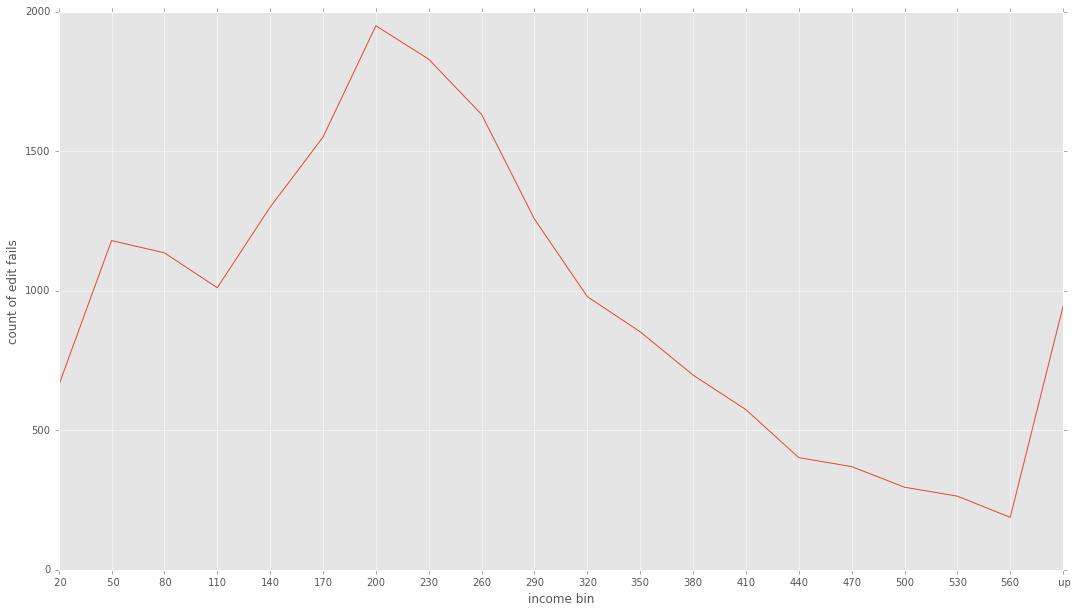

In [10]:
dist_edits_df = dist_edits_df[dist_edits_df.index < 25]
fails = plt.figure(figsize=(18,10))
xticks = [x[-3:] for x in dist_edits_df['bin']] #get top number of each bin range

ax = plt.subplot() #instantiate axis object to enable extra functions
x = range(len(dist_edits_df['bin'])) #set x axis range
plt.xticks(x,xticks) #set xtick names

y = dist_edits_df['count'] #set y axis values
plt.plot(x,y, label='edit fails')
plt.ylabel('count of edit fails')
plt.xlabel('income bin')
plt.show(fails)

In [84]:
frb_df.head()

,q001,q002,q003,q004,q005,q013,q014,q024,q025,q027,...,q044,q045,q046,q051,q052,q064,q066,q067,q068,year
0,11964.0,426.0,29.0,4.0,5.0,8470.0,6065.0,8066.0,59806.0,1608410.0,...,80706.0,55477.0,NaN,2295.0,40.0,235.0,7583.0,10035.0,41589.0,2004
1,15898.0,403.0,73.0,1.0,21.0,6519.0,7111.0,4435.0,61586.0,1709281.0,...,235812.0,89518.0,NaN,2100.0,10.0,73.0,6526.0,6726.0,37588.0,2005
2,13862.0,571.0,87.0,2.0,21.0,7981.0,8125.0,6424.0,61351.0,1507579.0,...,522885.0,142775.0,NaN,2192.0,5.0,19.0,6419.0,3903.0,32936.0,2006
3,13716.0,626.0,181.0,8.0,67.0,6490.0,10315.0,3561.0,44169.0,871609.0,...,205953.0,55794.0,NaN,82.0,4.0,29.0,2167.0,2960.0,33312.0,2007
4,38400.0,1860.0,38116.0,28.0,124.0,26084.0,25584.0,21908.0,139080.0,1970176.0,...,353824.0,57972.0,NaN,68.0,8.0,152.0,7160.0,11612.0,143708.0,2008
